
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Climate emulator output generation

inputs required: 
  * emulator output - synthetic wave and water level conditions associated to the future ENSO probability
  * Projected Sea Level Rise at the Site (for the intermediate SLR scenario, +1m)

  
in this notebook:
  * plot the synthetic values of the analyzed variables
  * generation of hourly values of the synthetic time series  


In [10]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..','..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.util.time_operations import xds_limit_dates, repair_times_hourly, add_max_storms_mask, fast_reindex_hourly, fast_reindex_hourly_nsim

from teslakit.plotting.outputs import Plot_Complete



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'

# offshore
db = Database(p_data)
db.SetSite('KWAJALEIN_emulator')

# climate change - S5
db_S5 = Database(p_data)
db_S5.SetSite('KWAJALEIN_CC_S5')


# Climate Emulator. simulation modified path
CE = Climate_Emulator(db_S5.paths.site.EXTREMES.climate_emulator)

n_sims_DWTs = 10



## Simulated Waves and Climate Data

In [3]:
def waves_hourly(CE, n_sim, n_sim_ce=0):
    '''
    Generate hourly simulation output. 
    
    - select one DWTs-WVS Climate emulator simulations
    - aggregate simulated waves storms
    - generate hourly hydrographs
    
    return xarray.Dataset with dims: time (hourly)
    '''

    # Load DWT --> WVS, TCs simulation 
    WVS_sim, TCS_sim, WVS_upd = CE.LoadSim(n_sim = n_sim)    
    WVS_sim = WVS_sim.isel(n_sim = n_sim_ce)  
    WVS_upd = WVS_upd.isel(n_sim = n_sim_ce)  
    TCS_sim = TCS_sim.isel(n_sim = n_sim_ce)
    
    # Poner NaN en WVS_upd_E donde Hs, Tp y Dir de Swell_1 y Swell_2 valen 0 (Hubo TC y sólo tenemos Sea family)
    ind = np.where(WVS_upd.swell_1_Tp==0.0)[0]
    vars = {'swell_1_Hs','swell_1_Tp','swell_1_Dir','swell_2_Hs','swell_2_Tp','swell_2_Dir'}
    for var in vars:
        WVS_upd[var][ind] = np.nan

    # aggregate waves families
    WVS_agr = Aggregate_WavesFamilies(WVS_upd, a_tp='max_energy')
    WVS_agr['mslp']=(['time'], WVS_sim.mslp.values)
    WVS_agr['wind_speed']=(['time'], WVS_sim.wind_speed.values)
    WVS_agr['wind_dir']=(['time'], WVS_sim.wind_dir.values)
        
    # calculate intradaily hourly hydrographs for simulated storms
    WVS_h = Intradaily_Hydrograph(WVS_agr, TCS_sim)
        
    # repair times: remove duplicates (if any)
    WVS_h = repair_times_hourly(WVS_h)
    
    # add mask for max_storms times
    WVS_h = add_max_storms_mask(WVS_h, WVS_upd.time.values)

    return WVS_h

In [4]:
# generate simulation covariates hourly data 

# load data
AWT = db_S5.Load_SST_AWT_sim()
MSL = db_S5.Load_TIDE_sim_mmsl()
MJO = db.Load_MJO_sim()
DWT = db_S5.Load_ESTELA_DWT_sim()
ATD_h = db.Load_TIDE_sim_astro()  # hourly data, 1 sim

# optional select total sims
if n_sims_DWTs != None:
    AWT = AWT.isel(n_sim=slice(0, n_sims_DWTs))
    MSL = MSL.isel(n_sim=slice(0, n_sims_DWTs))
    MJO = MJO.isel(n_sim=slice(0, n_sims_DWTs))
    DWT = DWT.isel(n_sim=slice(0, n_sims_DWTs))

# reindex data to hourly (pad)
AWT_h = fast_reindex_hourly_nsim(AWT)
MSL_h = fast_reindex_hourly_nsim(MSL)
MJO_h = fast_reindex_hourly_nsim(MJO)
DWT_h = fast_reindex_hourly_nsim(DWT)

# common dates limits
d1, d2 = xds_limit_dates([AWT_h, MSL_h, MJO_h, DWT_h, ATD_h])
AWT_h = AWT_h.sel(time = slice(d1, d2))
MSL_h = MSL_h.sel(time = slice(d1, d2))
MJO_h = MJO_h.sel(time = slice(d1, d2))
DWT_h = DWT_h.sel(time = slice(d1, d2))
ATD_h = ATD_h.sel(time = slice(d1, d2))

# copy to new dataset
times = AWT_h.time.values[:]
CVS = xr.Dataset(
    {
        'AWT': (('n_sim','time'), AWT_h.evbmus_sims.values[:].astype(int)),
        'MJO': (('n_sim','time'), MJO_h.evbmus_sims.values[:].astype(int)),
        'DWT': (('n_sim','time'), DWT_h.evbmus_sims.values[:].astype(int)),
        'MMSL': (('n_sim','time'), MSL_h.mmsl.values[:]),
        'AT': (('time',), ATD_h.astro.values[:]),
    },
    coords = {'time': times}
)



In [5]:
# iterate simulations
for n in range(n_sims_DWTs):
 
    # select covariates simulation
    CVS_s = CVS.sel(n_sim=n)

    # generate hourly waves
    WVS_s = waves_hourly(CE, n)
    
    # merge all data
    d1, d2 = xds_limit_dates([WVS_s, CVS_s])
    WVS_s = WVS_s.sel(time = slice(d1, d2))
    SIM = xr.combine_by_coords([WVS_s, CVS_s])
   
    # set AT reference level (mean at 0)
    SIM['AT'].values[:] = SIM['AT'] - np.nanmean(SIM['AT'])
    
    # calculate AWL, TWL and level
    SIM['AWL'] = AWL(SIM['Hs'], SIM['Tp'])
    SIM['TWL'] = SIM['AWL'] + SIM['SS'] + SIM['AT'] + SIM['MMSL']
    SIM['level'] = SIM['SS'] + SIM['AT'] + SIM['MMSL']
    
    # store hourly simulation offshore data
    db_S5.Save_SIM_OFFSHORE(SIM, n)
    
    print('simulation {0} processed.'.format(n))
    


simulation 0 processed.
simulation 1 processed.
simulation 2 processed.
simulation 3 processed.
simulation 4 processed.
simulation 5 processed.
simulation 6 processed.
simulation 7 processed.
simulation 8 processed.
simulation 9 processed.


<xarray.Dataset>
Dimensions:     (time: 8765832)
Coordinates:
  * time        (time) int64 262968 262969 262970 ... 9028797 9028798 9028799
Data variables:
    SS          (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MJO         (time) float32 23.0 23.0 23.0 23.0 23.0 ... 18.0 18.0 18.0 18.0
    level       (time) float32 0.12156281 0.1713034 ... -0.42882386 -0.617523
    wind_dir    (time) float32 72.83442 72.83442 72.83442 ... 65.06876 65.06876
    TWL         (time) float32 0.6400117 0.694461 ... -0.06725409 -0.259285
    AWT         (time) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 6.0 6.0 6.0 6.0 6.0
    AWL         (time) float32 0.5184489 0.5231576 ... 0.3615698 0.35823798
    max_storms  (time) float32 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MMSL        (time) float32 -0.12402187 -0.12402187 ... 0.0003353599
    Dir         (time) float32 53.38536 53.38536 53.38536 ... 60.08414 60.08414
    DWT         (time) float32 28.0 28.0 28.0 28.0 28.0 ... 29.0 

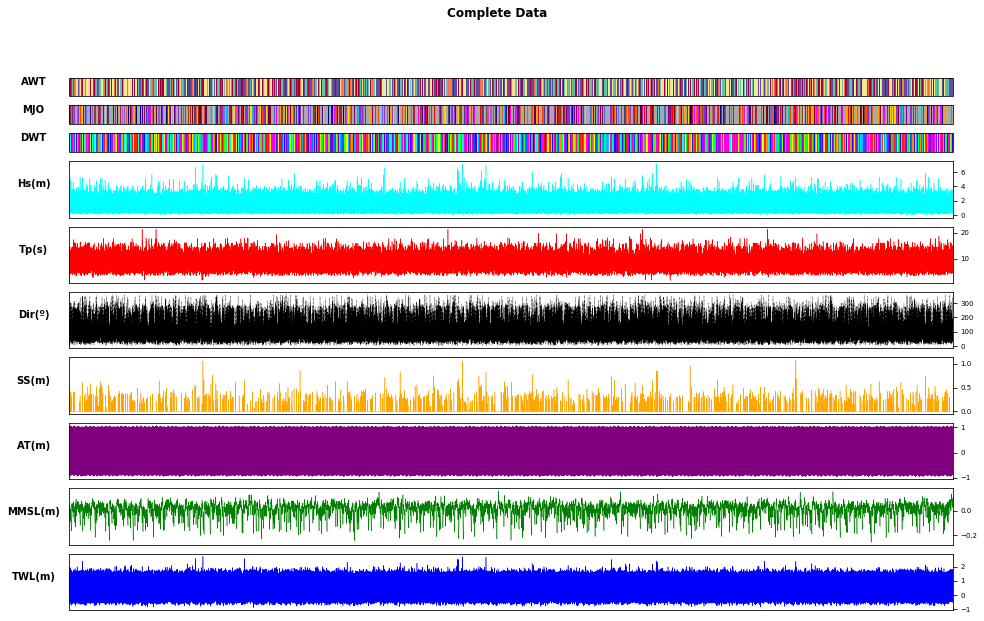

In [6]:
# Plot one Simulation 

n_sim = 0
SIM_p = db_S5.Load_SIM_OFFSHORE(n_sim)
print(SIM_p)

#Plot_Complete(SIM_p);


In [8]:
from teslakit.plotting.config import _faspect, _fsize, _fdpi
from teslakit.plotting.outputs import axplot_bmus, axplot_series
from matplotlib import gridspec

def Plot_Complete(xds):

    # parameters
    n_cs_AWT = 6
    n_cs_MJO = 25
    n_cs_DWT = 42


    # plot figure
    fig, axs = plt.subplots(
        13, 1,
        figsize=(_faspect*_fsize, _fsize),
    )

    # AWT
    axplot_bmus(axs[0], xds.AWT, n_cs_AWT, 'AWT')

    # MJO
    axplot_bmus(axs[1], xds.MJO, n_cs_MJO, 'MJO')

    # DWT
    axplot_bmus(axs[2], xds.DWT, n_cs_DWT, 'DWT')

    # HS
    axplot_series(axs[3], xds.Hs, 'solid', 'royalblue', 'Hs(m)')

    # TP
    axplot_series(axs[4], xds.Tp, 'solid', 'crimson', 'Tp(s)')

    # DIR
    axplot_series(axs[5], xds.Dir, 'dotted', 'black', 'Dir(º)')

    # SS
    axplot_series(axs[6], xds.SS, 'solid', 'orange', 'SS(m)')
        
    # MSLP
    axplot_series(axs[7], xds.mslp*0.01, 'solid', 'darkmagenta', 'mslp(mbar)')

    # WIND-DIR
    axplot_series(axs[8], xds.wind_dir, 'dotted', 'mediumseagreen', 'Wind Dir(°)')

    # WIND-SPEED
    axplot_series(axs[9], xds.wind_speed, 'solid', 'coral', 'Wind Speed(m/s)')

    # AT
    axplot_series(axs[10], xds.AT, 'solid', 'violet', 'AT(m)')

    # MMSL
    axplot_series(axs[11], xds.MMSL, 'solid', 'darkolivegreen', 'MMSL(m)')

    # TWL
    axplot_series(axs[12], xds.TWL, 'solid', 'mediumblue', 'TWL(m)')


    # suptitle
    fig.suptitle('Complete Data', fontweight='bold', fontsize=12)

    # reduce first 3 subplots
    gs = gridspec.GridSpec(13, 1, height_ratios = [1,1,1,3,3,3,3,3,3,3,3,3,3])
    for i in range(13):
        axs[i].set_position(gs[i].get_position(fig))
    
    plt.show()

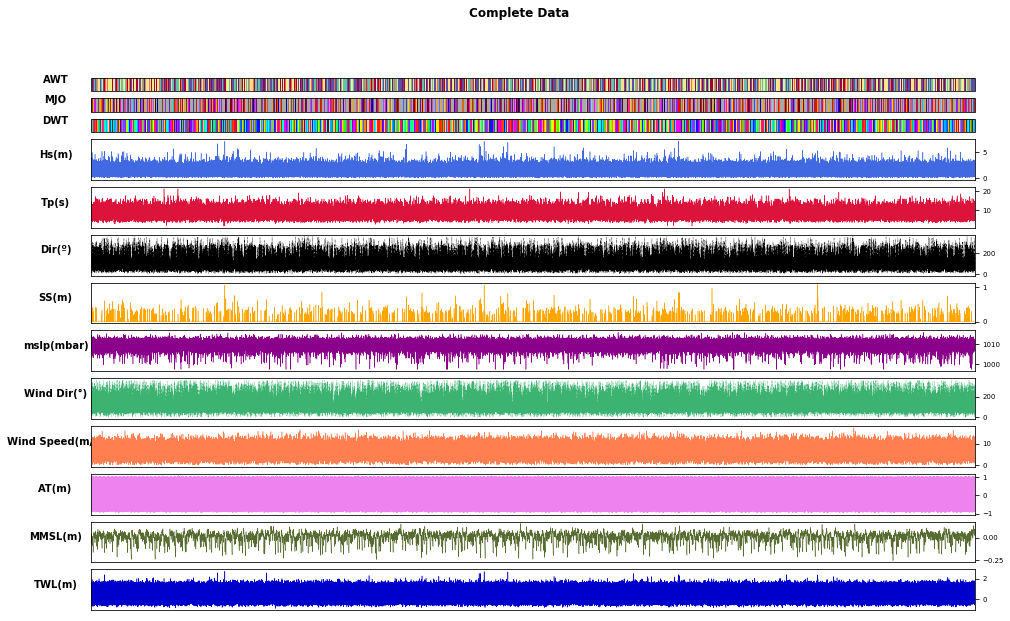

In [9]:
Plot_Complete(SIM_p)

### plot 100 yrs. of TWL taking into account SLR for intermediate scenario

In [12]:
# Load SLR file

SLR = db.Load_SeaLevelRise()
SLR['time'] = SLR.time.dt.round('H')

# Select intermediate scenario (+1.0)
SLR = SLR.sel(scenario='1.0')

print(SLR)

<xarray.Dataset>
Dimensions:   (time: 885360)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 ... 2100-12-31T23:00:00
    scenario  <U3 '1.0'
Data variables:
    SLR       (time) float32 ...


([<matplotlib.lines.Line2D at 0x11e0435c0>],
 [],
 (0, 885360),
 <matplotlib.legend.Legend at 0x32f3e9320>)

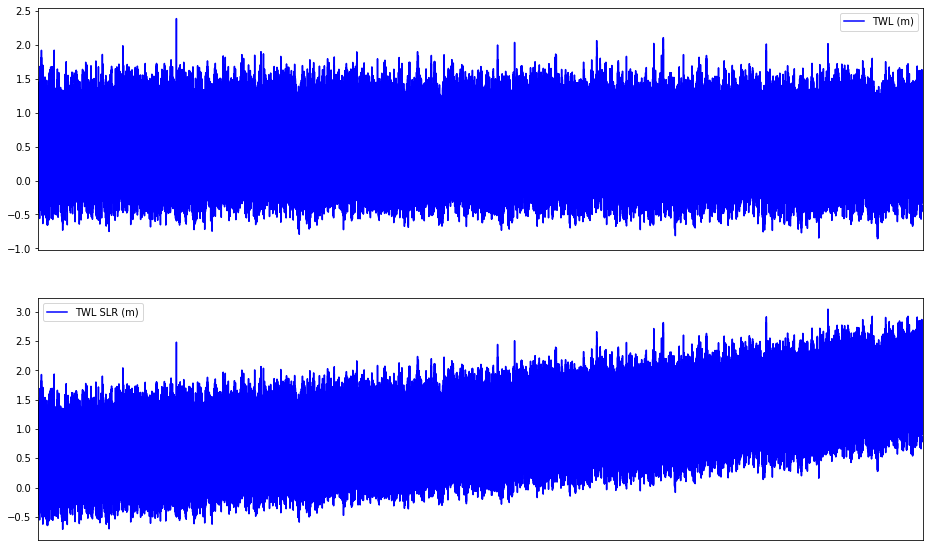

In [13]:
# Keep first 100 years of simulation
SIM_p = SIM_p.isel(time=slice(0, len(SLR.time))) # 100 years

# Add SLR to TWL
SIM_p['TWL_SLR'] = SIM_p['TWL'] + SLR['SLR'].values


# plot figure
from teslakit.plotting.config import _faspect, _fsize
import matplotlib.gridspec as gridspec

fig, axs = plt.subplots(2, 1, figsize=(_faspect*_fsize, _fsize));

# Sim
axs[0].plot(SIM_p.TWL.values, label='TWL (m)', color='blue'), axs[0].set_xticks([]), axs[0].set_xlim(0,len(SIM_p.time)), axs[0].legend()

# Sim with SLR S2
axs[1].plot(SIM_p.TWL_SLR.values, label='TWL SLR (m)', color='blue'), axs[1].set_xticks([]), axs[1].set_xlim(0,len(SIM_p.time)), axs[1].legend()
